In [1]:
#import relevant modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statistics import mode
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

%matplotlib inline


c:\Users\mtort\Repositories\3W-Anomaly\venv\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [23]:
# all data files downloaded from kaggle are in a folder called '3W', seperated into folders by error number ('0', '1', '2', etc)
def loop_directory(folder: str, error_folder: str, type: str):
    '''
    Loop files in the directory of files by oil well type ("WELL", "DRAWN", "SIMULATED.)
    Citation: Modified version of tutorial code by Khuyen Tran
    https://towardsdatascience.com/3-python-tricks-to-read-create-and-run-multiple-files-automatically-5221ebaad2ba
   
    Inputs:
    folder <- name of folder where data is stored in
    error_folder <- str() of error code number (0-9) accessed as subdirectory
    type <- well measurement type ("WELL", "DRAWN", "SIMULATED") to access files
    '''
   
    dir_list = []
    type = type.upper()
    # Open main data folder, look through each error sub-folder
    for filename in os.listdir(folder+error_folder):
        if filename.startswith(type):
            file_directory = os.path.join(folder+error_folder, filename)
            file_read = pd.read_csv(file_directory)
            dir_list.append(file_read)
    return dir_list

In [24]:
# turns list of csv files into dictionary so we can divide data by error code or well type
def batch_dict_maker(batch_code_start=0, batch_code_end=8, class_bool=True, nafill=True):
    '''
    Utilize loop_directory to turn csv files into a nested dictionary of oil sensor data, seperated by error type and well type.
    Note: class_bool dictates wether the class column will report the error type (False) or simply wether there was an error (True) as 0-1
    Input: int(0-8), int(0-8), bool, bool
    Output: dict
    '''
    main_data_dir = 'data/'
    batch = {}
    for batch_number in range(batch_code_start,batch_code_end+1):
        print(f"Creating batch: {batch_number}")
        batch[batch_number] = {}
        # Seperate csv files by the measurement methon (pulled from csv name)
        for type in ["WELL", "DRAWN", "SIMULATED"]:
            batch[batch_number][type] = loop_directory(main_data_dir, str(batch_number), type)
            # for
            for df in batch[batch_number][type]:
                df['timestamp'] =  pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
                # Drop unnecesarry columns
                df.drop(columns = ["QGL"], inplace = True)
                # OPTIONAL: decide wether error values are variable of binary
                if class_bool==True:
                    df["class"]=df["class"].astype(bool).astype(int)
                # fill in NA's with zeros since tslearn does not accpect NA values
                if nafill==True:
                    df.fillna(0, inplace=True)
    print("Batch making complete")
    return batch
 
batch = batch_dict_maker(class_bool=False)

Creating batch: 0
Creating batch: 1
Creating batch: 2
Creating batch: 3
Creating batch: 4
Creating batch: 5
Creating batch: 6
Creating batch: 7
Creating batch: 8
Batch making complete


In [20]:
# Tslearn and sklearn like having its data into the X that we input into the model and the Y that we test for
# Data from csv files is in intervals of ~daily data, which is too big for machine learning
# we split up that large time series data into smaller time series, in this case 60 second intervals.
 
def total_data_compiler(batch=batch, seconds=60, x_column_start=1, x_column_end=7):
    '''
    From nested dictionary of wells, creates a tuple of two lists, one being a time series dataset and another being a list of class values
    Note: use parameters to edit length of time series input for model and which variable columns are considered
    Input: nested dict, int, int, int
    Output: tuple of 2 lists (time series dataset, class values)
    '''
    X = []
    y = []
    for batch_number in batch:
        for well_type in batch[batch_number]:
            print(f"Currently working on batch ({batch_number},  {well_type})")
            for well in batch[batch_number][well_type]:
                interval_amounts = len(well)//(seconds)
                for interval in range(0, interval_amounts - 1):
                    well_portion = well.iloc[seconds*interval : seconds*(interval+1)]
                    X.append(well_portion.iloc[:, x_column_start : x_column_end])
                    y.append(int(mode(well_portion["class"])))
    X = to_time_series_dataset(X)
    print("time series conversion complete")
    return (X, y)
 
 
total_data = total_data_compiler(batch, seconds=60)
 
 
 
#total_data = ((60 seconds of time series data, what error type it is), (another 60 seconds, another error type), (etc))
 
# intervals = [10, 30, 60, 120, 300]
# total_data_time_list = []
# for time_interval in intervals:
#     interval_data = total_data_compiler(batch, seconds=time_interval)
 
 
#total data is main time series dataset, contains entirety of data
#ensuring that the time series has shape (n_ts number of time series, max_sz length of largest series, d dimensions of series)
total_data[0].shape


Currently working on batch (0,  WELL)
Currently working on batch (0,  DRAWN)
Currently working on batch (0,  SIMULATED)
Currently working on batch (1,  WELL)
Currently working on batch (1,  DRAWN)
Currently working on batch (1,  SIMULATED)
Currently working on batch (2,  WELL)
Currently working on batch (2,  DRAWN)
Currently working on batch (2,  SIMULATED)
Currently working on batch (3,  WELL)
Currently working on batch (3,  DRAWN)
Currently working on batch (3,  SIMULATED)
Currently working on batch (4,  WELL)
Currently working on batch (4,  DRAWN)
Currently working on batch (4,  SIMULATED)
Currently working on batch (5,  WELL)
Currently working on batch (5,  DRAWN)
Currently working on batch (5,  SIMULATED)
Currently working on batch (6,  WELL)
Currently working on batch (6,  DRAWN)
Currently working on batch (6,  SIMULATED)
Currently working on batch (7,  WELL)
Currently working on batch (7,  DRAWN)
Currently working on batch (7,  SIMULATED)
Currently working on batch (8,  WELL)
Cu

(845483, 60, 6)

In [21]:
#total data is main time series dataset, contains entirety of data
#ensuring that the time series has shape (n_ts number of time series, max_sz length of largest series, d dimensions of series)
total_data[0].shape

(845483, 60, 6)

In [25]:
#extract only sample of full data for testing, scrap data outside of sample
def sampler(total_data, percent_kept):
    X, X_scrap, y, y_scrap = train_test_split(total_data[0], total_data[1], train_size=percent_kept, random_state=42)
    return (X, y)



In [26]:
def knn_report(sample_size=0.001,k=1):
    #keep a portion of the data for the analysis, ignore the rest
    total_data_sample = sampler(total_data, sample_size)
    print(f"The length of the sample dataset:", len(total_data_sample[0]))
 
    #split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(total_data_sample[0], total_data_sample[1], train_size=0.8,random_state=42)
    print(len(X_train), len(X_test), len(y_train), len(y_test))
 
    #knn learning
    model = KNeighborsTimeSeriesClassifier(n_neighbors = k, metric="dtw")
    model.fit(X_train, y_train)
    print("Machine Learning Model ready!")
    predicted = model.predict(X_test)
    expected = y_test
 
    # return classification report
    report = classification_report(expected, predicted, output_dict=True)
    return report


In [28]:
def knn_f1_score(sample_size=0.001, runs=10):
    '''
    Collects a list of f1 scores for knn clustering for different values of k (always odd)
    Input: int, int
    Output: list
    '''
    total_data_sample = sampler(total_data, sample_size)
 
    print(f"The length of the sample dataset:", len(total_data_sample[0]))
   
    #split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(total_data_sample[0], total_data_sample[1], train_size=0.8,random_state=42)
    print(len(X_train), len(X_test), len(y_train), len(y_test))
 
    #learning and reporting of f1 scores
    f1_list = []
    for k in range(0, runs):
        model = KNeighborsTimeSeriesClassifier(n_neighbors = (1+2*k), metric="dtw")
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        expected = y_test
        score = f1_score(expected, predicted, average="weighted")
        f1_list.append(score)
        print(f"Model {1+2*k} ready!")
    return f1_list



The length of the sample dataset: 845
676 169 676 169
Model 1 ready!
Model 3 ready!
Model 5 ready!
Model 7 ready!
Model 9 ready!
Model 11 ready!
Model 13 ready!
Model 15 ready!
Model 17 ready!
Model 19 ready!
Model 21 ready!
Model 23 ready!
Model 25 ready!
Model 27 ready!
Model 29 ready!
Model 31 ready!
Model 33 ready!
Model 35 ready!
Model 37 ready!
Model 39 ready!
Model 41 ready!
Model 43 ready!
Model 45 ready!
Model 47 ready!
Model 49 ready!


C:\Users\mtort\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


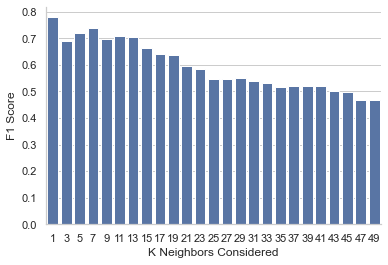

In [29]:
#graph out the effect of k on the model at (sample_size=0.001)
scores = knn_f1_score(sample_size=0.001, runs=25)
x = [1 + 2*i for i in range(25)]
 
#plot in high definition, save file
sns.set_theme(style="whitegrid")
sns.barplot(x, scores, color="b")
plt.rcParams['figure.dpi'] = 3000
plt.rcParams['savefig.dpi'] = 3000
plt.xlabel("K Neighbors Considered")
plt.ylabel("F1 Score")
sns.despine()

In [ ]:
def knn_report(sample_size=0.001,k=1):
    #keep a portion of the data for the analysis, ignore the rest
    total_data_sample = sampler(total_data, sample_size)
    print(f"The length of the sample dataset:", len(total_data_sample[0]))
 
    #split into training and testing
    X_train, X_test, y_train, y_test = train_test_split(total_data_sample[0], total_data_sample[1], train_size=0.8,random_state=42)
    print(len(X_train), len(X_test), len(y_train), len(y_test))
 
    #knn learning
    model = KNeighborsTimeSeriesClassifier(n_neighbors = k, metric="dtw")
    model.fit(X_train, y_train)
    print("Machine Learning Model ready!")
    predicted = model.predict(X_test)
    expected = y_test
 
    # return classification report
    report = classification_report(expected, predicted, output_dict=True)
    return report



In [ ]:
#Creates a classification report searborn heatmap for KNN clustering with k=3 and 845 samples.
 
#change sample_size and k inputs to your disgretion
report = knn_report(sample_size=0.005, k=3)
 
print(report)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.rcParams['figure.dpi'] = 3000
plt.rcParams['savefig.dpi'] = 3000
sns.color_palette("vlag", as_cmap=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap="RdYlGn", ax=ax)
#plt.title("KNN Clustering (n=3)\nSample size: 845\n", {'fontsize':15, 'fontweight':"bold"})
plt.show()

The length of the sample dataset: 4227
3381 846 3381 846
Machine Learning Model ready!
{'0': {'precision': 0.8854625550660793, 'recall': 0.9262672811059908, 'f1-score': 0.9054054054054055, 'support': 217}, '1': {'precision': 0.75, 'recall': 0.8571428571428571, 'f1-score': 0.7999999999999999, 'support': 42}, '2': {'precision': 0.8571428571428571, 'recall': 0.6666666666666666, 'f1-score': 0.75, 'support': 9}, '3': {'precision': 1.0, 'recall': 0.9466666666666667, 'f1-score': 0.9726027397260273, 'support': 75}, '4': {'precision': 1.0, 'recall': 0.9148936170212766, 'f1-score': 0.9555555555555556, 'support': 47}, '5': {'precision': 0.746268656716418, 'recall': 0.8875739644970414, 'f1-score': 0.8108108108108107, 'support': 169}, '6': {'precision': 0.6901408450704225, 'recall': 0.7424242424242424, 'f1-score': 0.7153284671532847, 'support': 66}, '8': {'precision': 0.5714285714285714, 'recall': 1.0, 'f1-score': 0.7272727272727273, 'support': 8}, '101': {'precision': 0.8266666666666667, 'recall':